*************************************************
# Energy Calibration
*************************************************

In this notebook, we determine the energy of the recoils within the absorber crystal. For this procedure, we need a peak in our spectrum that originates in a calibration source, i.e. a source of recoils with known energy. From this peak, we first calculate a CPE factor, that is a linear mapping between injected test pulse amplitudes and recoil energies. In the secons step, we do a polynomail fit between measured pulse heights and injected test pulse amplitudes, to account for nonlinearities in the detector signal.

In [1]:
import cait as ai
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

In [2]:
path_data = 'test_data/'
fname = 'test_001'
channels_rdt = [0,1]
channels_h5 = [0,1]

In [3]:
dh = ai.DataHandler(channels=channels_rdt)
dh.set_filepath(path_h5=path_data,
                fname=fname,
                appendix=False)  # this specifies, that the file does not have a "-P_Ch0..." appendix

DataHandler Instance created.


## Rate and Stability Cuts

Before we can start with the energy calibration, we need to do several checks on our data. First, is the trigger rate stabile over the measurement time?

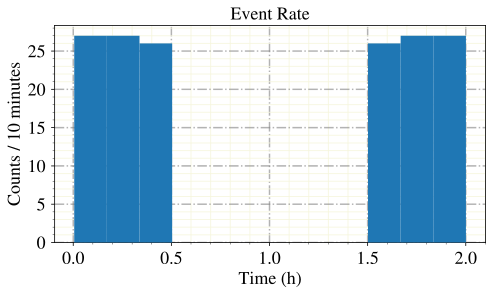

In [4]:
dh.show_values(group='events', key='hours', bins=12, 
               xlabel='Time (h)', ylabel='Counts / 10 minutes', title='Event Rate')

The gap in the histogram above is due to the fact that we use a file that was merged from two consecutive measurements (simulation, actually, in our case). Away from the gap the trigger rate is stable. The second check is, if the control pulse heights are stable.

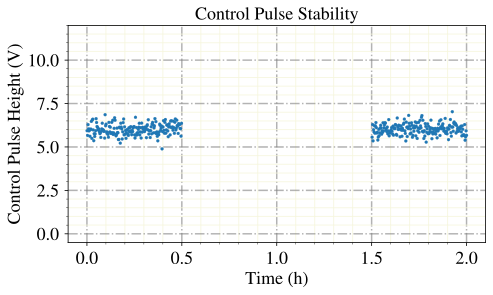

In [5]:
dh.show_scatter(groups=['controlpulses', 'controlpulses'],
                        keys=['hours', 'pulse_height'],
                        idx0s=[None, 0],
                        xlabel='Time (h)',
                        ylabel='Control Pulse Height (V)',
                        yran=(-0.5, 12),
                        title='Control Pulse Stability'
                        )

Well, they are. Other than for the control pulses in the CSMPL files (which we saw in the previous notebook), we included some variations for the control pulses in the hardware data files, to demonstrate a stability plot and cut. But first we also look at the stability of the test pulses.

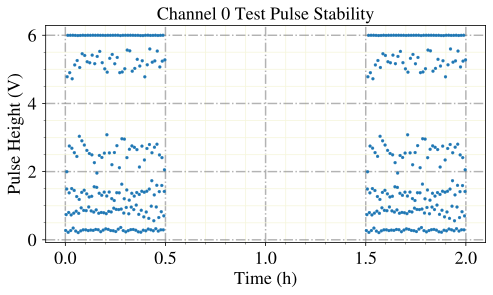

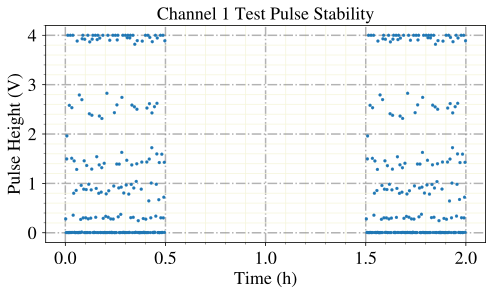

In [6]:
for c in [0,1]:
    dh.show_scatter(groups=['testpulses', 'testpulses'],
                    keys=['hours', 'mainpar'],
                    idx0s=[None, c],
                    idx2s=[None, 0],
                    xlabel='Time (h)',
                    ylabel='Pulse Height (V)',
                    marker='.',
                    title='Channel {} Test Pulse Stability'.format(c)
                    )

All stable. However, jsut for demonstration purposes, we can calculate a stability cut on the control pulses. For this we add a flag to the events group in the HDF5 file, that determines if the event is in between two stable control pulses. A control pulses is defined as stable if its height does not exceed the upper and lower bounds and does not deviate more than significance * sigma from the mean control pulse height.

In [7]:
dh.calc_controlpulse_stability(channel=0, significance=3, lb=5, ub=7.5)

Do Testpulse Stability Cut
Control Pulse PH 6.019 +- 0.306, within 3 sigma: 99.500 %
Good Control Pulses: 398/400 (99.500%)
Good Events: 157/160 (98.125%)
Good Time: 0.989h/2.000h (49.458%)


The same we can do for the rate, where we flag all events as bad that are not in 10-minute intervals with a rate that does not exceed bounds and does not deviate more than sigma * significance from the average rate.

In [8]:
dh.calc_rate_cut()

Do Rate Cut.
Rate: (13.250 +- 13.255)/10m
Good Rate per 10m (3 sigma): 0.000 - 53.014
Good Time: 2.000h/2.000h (100.000%)
Good Events: 159.000/160.000 (99.375%)


We can later access these cut flags with the dh.get(group='events', dataset='controlpulse_stability') and dh.get(group='events', dataset='rate_cut') methods and include them in any cuts we want.

## Find CPE Factor

In [9]:
channels = [0, 1]

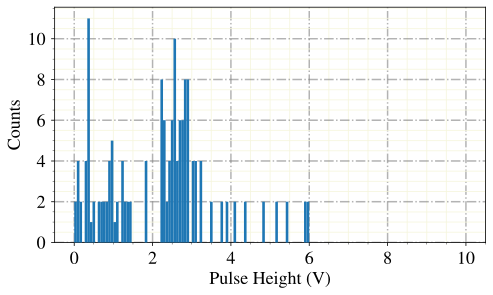

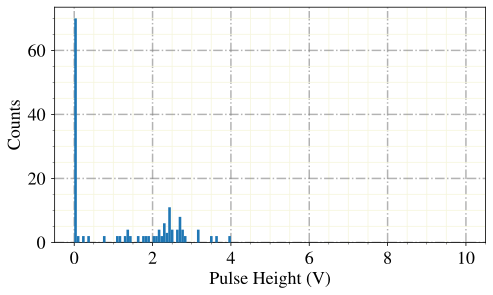

In [10]:
for c in channels:
    dh.show_values(group='events', key='mainpar', bins=150, idx0=c, idx2=0, range=(0, 10),
               xlabel='Pulse Height (V)', ylabel='Counts')

In [11]:
ph = dh.get('events','mainpar')[:, :, 0]
lb = [2.5, 2]
ub = [3.5, 3]
calibration_peak = []

for c in channels:
    peak_events = ai.cuts.LogicalCut(initial_condition=ph[c]>lb[c])
    peak_events.add_condition(ph[c]<ub[c])

    calibration_peak.append(np.mean(ph[c, peak_events.get_idx()]))
    print('Peak position with PH: ', calibration_peak[-1])

Peak position with PH:  2.8434481620788574
Peak position with PH:  2.4624580502510076


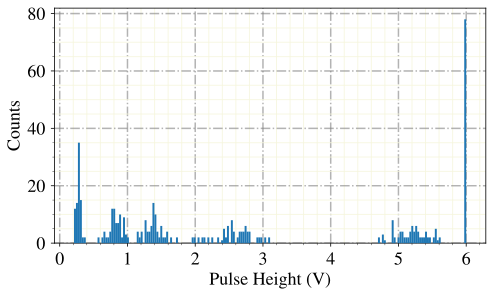

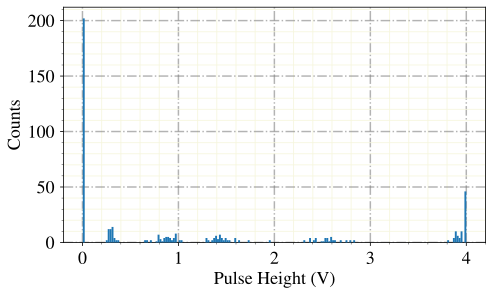

In [12]:
for c in channels:
    dh.show_values(group='testpulses', key='mainpar', bins=200, idx0=c, idx2=0,
                   xlabel='Pulse Height (V)', ylabel='Counts')

In [13]:
ph_tp = dh.get('testpulses','mainpar')[:, :, 0]
tpas = dh.get('testpulses','testpulseamplitude')
    
tpa_peaks = []
lower_bounds = [0.6, 1.1]
upper_bounds = [1.2, 1.8]
two_tpas = [0.3, 0.5]

for c in channels:
    two_peaks = []
    for i, val in enumerate(two_tpas):
        peak_events = ai.cuts.LogicalCut(initial_condition=ph_tp[c] > lower_bounds[i])
        peak_events.add_condition(ph_tp[c] < upper_bounds[i])
        peak_events.add_condition(np.isclose(tpas, val))
        two_peaks.append(np.mean(ph_tp[c, peak_events.get_idx()]))
        print('Channel {}: Peak position TPA {} from {} events, with PH: {}'.format(c, val, len(peak_events.get_idx()), two_peaks[-1]))
    tpa_peaks.append(two_peaks)

Channel 0: Peak position TPA 0.3 from 78 events, with PH: 0.8314782318396448
Channel 0: Peak position TPA 0.5 from 80 events, with PH: 1.3893630003184079
Channel 1: Peak position TPA 0.3 from 54 events, with PH: 0.8722513597320628
Channel 1: Peak position TPA 0.5 from 50 events, with PH: 1.450446393609047


In [14]:
energy_calibration_peak = 5.89  # iron line
cpe_factor = []

for c in channels:
    tpa_calibration_peak = two_tpas[0] + (calibration_peak[c] - tpa_peaks[c][0])*(two_tpas[1] - two_tpas[0])/(tpa_peaks[c][1] - tpa_peaks[c][0])
    print('Channel {}: The TPA corresponding to the calibration peak is {} V.'.format(c, tpa_calibration_peak))
    cpe_factor.append(energy_calibration_peak / tpa_calibration_peak)
    print('Channel {}: The CPE factor is then {} keV/V.'.format(c, cpe_factor[-1]))

Channel 0: The TPA corresponding to the calibration peak is 1.0212851269359584 V.
Channel 0: The CPE factor is then 5.767243490239668 keV/V.
Channel 1: The TPA corresponding to the calibration peak is 0.8500589238396241 V.
Channel 1: The CPE factor is then 6.928931436182691 keV/V.


## Energy Calibration

In [15]:
for c in channels:
    dh.calc_testpulse_stability(c, significance=1)

Do Control Pulse Stability Cut
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]
Testpulses after Noise Cut: 478/478 (100.000%)
TPA 0.100 with PH 0.279 +- 0.032, within 1 sigma: 68.750 %
TPA 0.300 with PH 0.825 +- 0.100, within 1 sigma: 67.500 %
TPA 0.500 with PH 1.389 +- 0.129, within 1 sigma: 70.000 %
TPA 1.000 with PH 2.564 +- 0.275, within 1 sigma: 70.000 %
TPA 3.000 with PH 5.193 +- 0.227, within 1 sigma: 62.500 %
TPA 10.000 with PH 5.997 +- 0.002, within 1 sigma: 76.923 %
Good Testpulses: 331/478 (69.247%)
Good Events: 102/160 (63.750%)
Good Time: 0.670h/1.998h (33.528%)
Do Control Pulse Stability Cut
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]
Testpulses after Noise Cut: 349/478 (73.013%)
TPA 0.100 with PH 0.252 +- 0.115, within 1 sigma: 79.310 %
TPA 0.300 with PH 0.760 +- 0.304, within 1 sigma: 87.097 %
TPA 0.500 with PH 1.153 +- 0.591, within 1 sigma: 79.365 %
TPA 1.000 with PH 1.862 +- 1.120, wi

Energy Calibration for Channel  0
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]


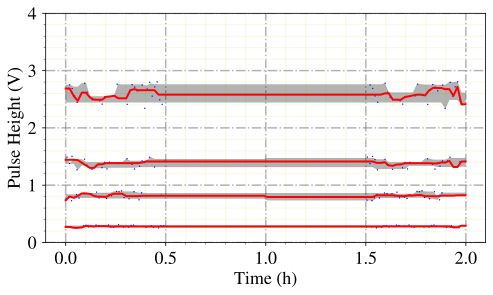

Plot Regression Polynomial at 0.999 hours.


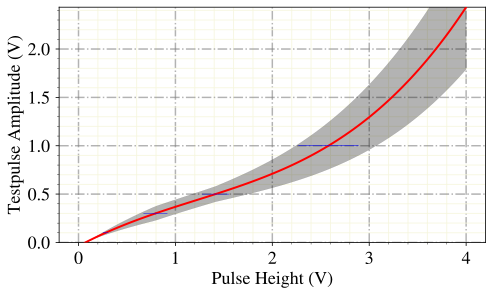

Calculating Recoil Energies: 0.0 %
Energy Calibration for Channel  1
Unique TPAs:  [ 0.1         0.30000001  0.5         1.          3.         10.        ]


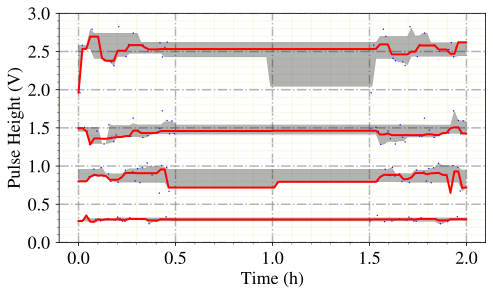

Plot Regression Polynomial at 0.999 hours.


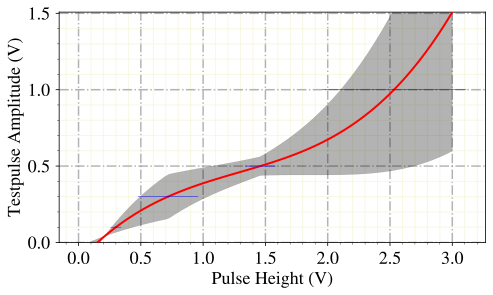

Calculating Recoil Energies: 0.0 %
Finished.


In [16]:
dh.calc_calibration(starts_saturation=[4,3],
                        cpe_factor=cpe_factor,
                        plot=True,
                        only_stable=True,
                        tree=True,
                        linear_with_uncertainty=False,
                        #cut_flag=cut_flag,
                        poly_order=3,
                        )